# Notebook for visualizing the results of a stylegan3 training


In [1]:
import os

dataset_name = f"ulla"

results_dir = f"training-runs/{dataset_name.upper()}_TRAIN"
experiment_name = f"00001-stylegan3-t-{dataset_name}_train-gpus1-batch32-gamma0.125"

file_name = "stats.jsonl"
training_options_file_name = "training_options.json"
dataset_summary_file_name = f"data/{dataset_name}/patches/processing_summary.json"

file_path = os.path.join(results_dir, experiment_name, file_name)
if not os.path.isfile(file_path):
    print(f"Error: The file {file_path} does not exist.")

import json

with open(dataset_summary_file_name, "r") as f:
    summary = json.load(f)

label_map = summary.get("label_map", {})
print("Label Map:", label_map)

# Labels for the classes
class_labels = list(label_map.values())
print("Class Labels:", class_labels)


Label Map: {'2': 1, '4': 3, '7': 6, '8': 7, '9': 8}
Class Labels: [1, 3, 6, 7, 8]


In [2]:
from visualization_utils import read_jsonl, extract_metrics, extract_classification_metrics, format_time, summarize_training_stats, \
    summarize_training_options, extract_confusion_matrix, plot_confusion_matrix, plot_metric, print_accuracies_per_class, \
    compute_avg_accuracy, compute_overall_accuracy, plot_accuracies, extract_best_tick, class_colors

In [3]:
summarize_training_options(os.path.join(results_dir, experiment_name, training_options_file_name))

False
📋 Training Configuration Summary
────────────────────────────────────
⚖️  Class weight: 0.1
🖥️  Number of GPUs: 1
📦 Batch size: 32
🎯 Uniform class labels: False
🧪 Discriminator on generated images: True
🎛️  ADA target present ✅ → Value: 0.6


In [4]:
jsonl_data = read_jsonl(file_path)
metrics = extract_metrics(jsonl_data, class_labels=class_labels)
summarize_training_stats(metrics, exclude_first_tick=True)

🕒 Total time: 3min 49s
📊 Total kimg: 2.016
📈 Total ticks: 1
⏱️ Mean time per tick: 2min 47s (std: 0s)
⏳ Mean time per kimg: 1min 24s (std: 0s)


In [5]:
print("────────────────────────────────────")
print("Using average accuracy as performance key")
print("────────────────────────────────────")
best_tick_performance = extract_best_tick(
    jsonl_data, class_labels, performance_key="avg", verbose=True, only_tick_with_pkl=False, network_snapshot_ticks=None
)

────────────────────────────────────
Using average accuracy as performance key
────────────────────────────────────
📊 Best Tick Performance Summary
────────────────────────────────────
⏱️  Tick: 1
🖼️  kimg: 2.016
📈 Avg Accuracy (Train): 0.4520 ± 0.4159
📊 Avg Accuracy (Val):   0.5524 ± 0.4593
🏁 Overall Accuracy (Train): 0.7964
✅ Overall Accuracy (Val):   0.8906


In [6]:
print("\n────────────────────────────────────")
print("Using overall accuracy as performance key")
print("────────────────────────────────────")
best_tick_performance = extract_best_tick(
    jsonl_data,
    class_labels,
    performance_key="overall",
    verbose=True,
    only_tick_with_pkl=False,
    network_snapshot_ticks=None,
)


────────────────────────────────────
Using overall accuracy as performance key
────────────────────────────────────
📊 Best Tick Performance Summary
────────────────────────────────────
⏱️  Tick: 1
🖼️  kimg: 2.016
📈 Avg Accuracy (Train): 0.4520 ± 0.4159
📊 Avg Accuracy (Val):   0.5524 ± 0.4593
🏁 Overall Accuracy (Train): 0.7964
✅ Overall Accuracy (Val):   0.8906


In [7]:
print("\n────────────────────────────────────")
print("Considering only saved ticks with pkl files")
print("────────────────────────────────────\n")
print("────────────────────────────────────")
print("Using average accuracy as performance key")
print("────────────────────────────────────")
best_tick_performance = extract_best_tick(
    jsonl_data, class_labels, performance_key="avg", verbose=True, only_tick_with_pkl=True, network_snapshot_ticks=1
)

print("\n────────────────────────────────────")
print("Using overall accuracy as performance key")
print("────────────────────────────────────")
best_tick_performance = extract_best_tick(
    jsonl_data, class_labels, performance_key="overall", verbose=True, only_tick_with_pkl=True, network_snapshot_ticks=1
)


────────────────────────────────────
Considering only saved ticks with pkl files
────────────────────────────────────

────────────────────────────────────
Using average accuracy as performance key
────────────────────────────────────
📊 Best Tick Performance Summary
────────────────────────────────────
⏱️  Tick: 1
🖼️  kimg: 2.016
📈 Avg Accuracy (Train): 0.4520 ± 0.4159
📊 Avg Accuracy (Val):   0.5524 ± 0.4593
🏁 Overall Accuracy (Train): 0.7964
✅ Overall Accuracy (Val):   0.8906

────────────────────────────────────
Using overall accuracy as performance key
────────────────────────────────────
📊 Best Tick Performance Summary
────────────────────────────────────
⏱️  Tick: 1
🖼️  kimg: 2.016
📈 Avg Accuracy (Train): 0.4520 ± 0.4159
📊 Avg Accuracy (Val):   0.5524 ± 0.4593
🏁 Overall Accuracy (Train): 0.7964
✅ Overall Accuracy (Val):   0.8906


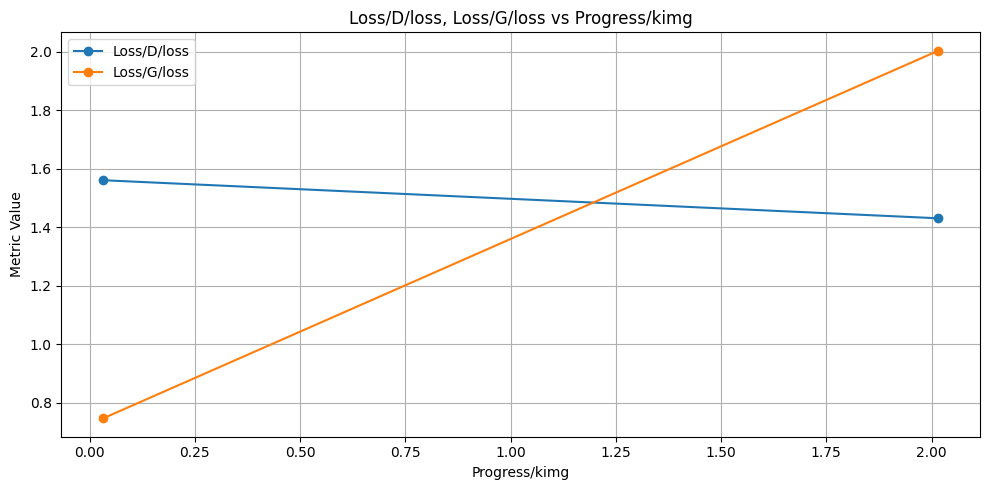

In [8]:
plot_metric(metrics, metrics=["Loss/D/loss", "Loss/G/loss"], x_axis="Progress/kimg")

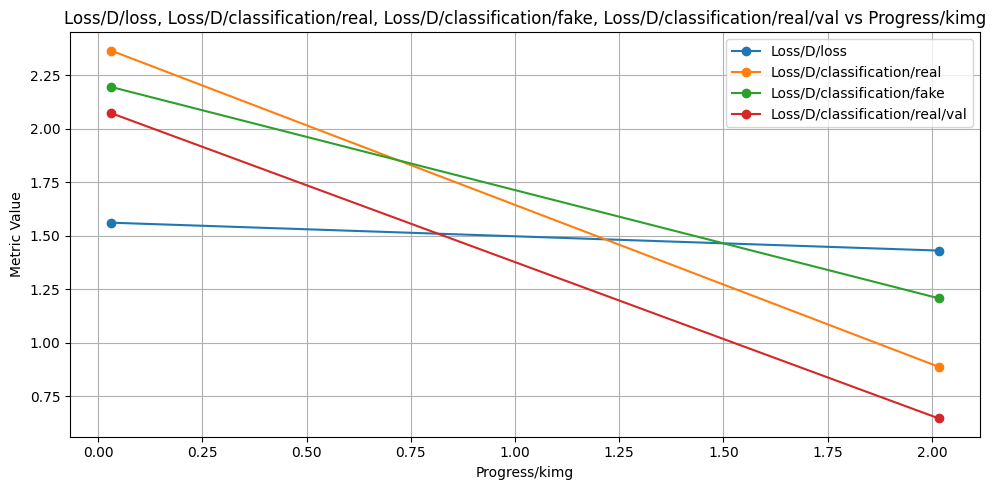

In [9]:
plot_metric(
    data=metrics,
    metrics=[
        "Loss/D/loss",
        "Loss/D/classification/real",
        "Loss/D/classification/fake",
        "Loss/D/classification/real/val",
    ],
    x_axis="Progress/kimg",
)

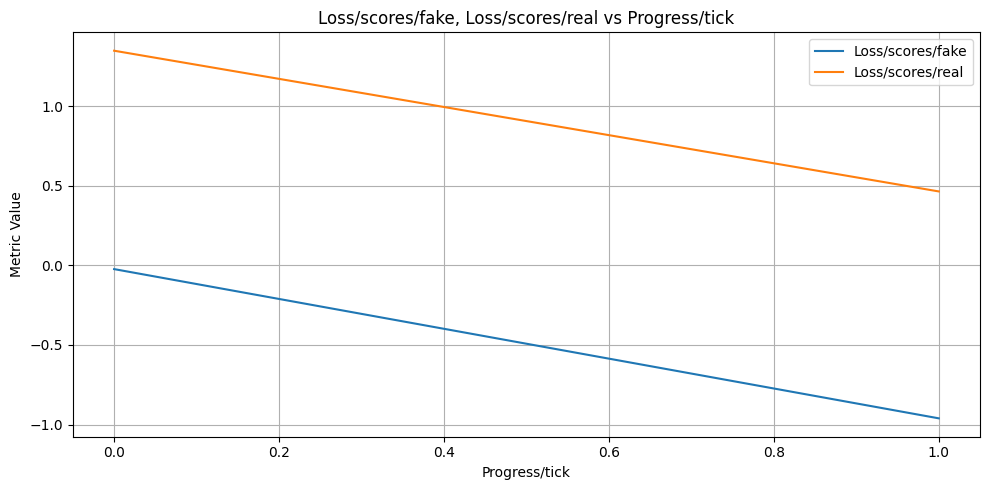

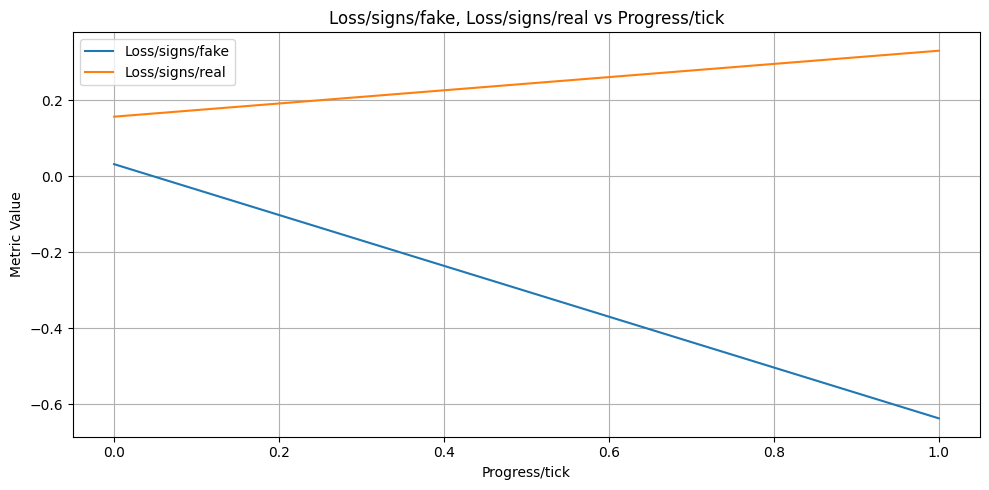

In [10]:
plot_metric(metrics, metrics=["Loss/scores/fake", "Loss/scores/real"], x_axis="Progress/tick", marker=None)
plot_metric(metrics, metrics=["Loss/signs/fake", "Loss/signs/real"], x_axis="Progress/tick", marker=None)

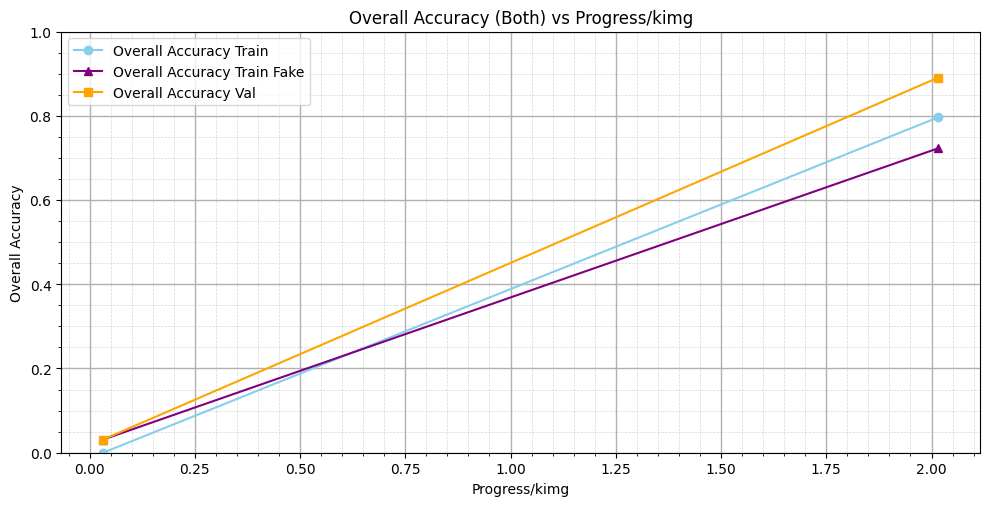

In [11]:
classification_metrics = extract_classification_metrics(jsonl_data, class_labels=class_labels)
metrics["overall_accuracy_train"], metrics["overall_accuracy_val"], metrics["overall_accuracy_train_fake"] = (
    compute_overall_accuracy(classification_metrics)
)
plot_accuracies(
    metrics,
    class_labels=class_labels,
    plot_std_in_avg_accuracy=False,
    plot_type="overall",
    dataset="both",
    include_fake=True,
)

Last 10 accuracies per class (val):
Class 1: ['0.000', '1.000']
Class 3: ['0.000', '0.000']
Class 6: ['0.000', '0.762']
Class 7: ['0.051', '1.000']
Class 8: ['0.000', '0.000']
Average accuracies over the last 10 ticks: ['0.010', '0.552']


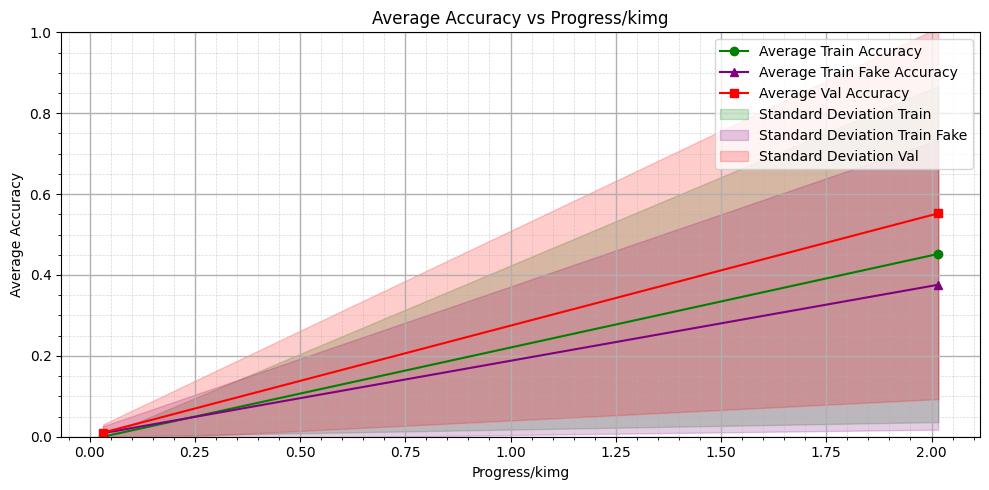

In [12]:
print_accuracies_per_class(metrics, class_labels, last_ticks=10, data_type="val")
plot_accuracies(
    metrics,
    class_labels=class_labels,
    plot_std_in_avg_accuracy=True,
    plot_type="average",
    dataset="both",
    include_fake=True,
)

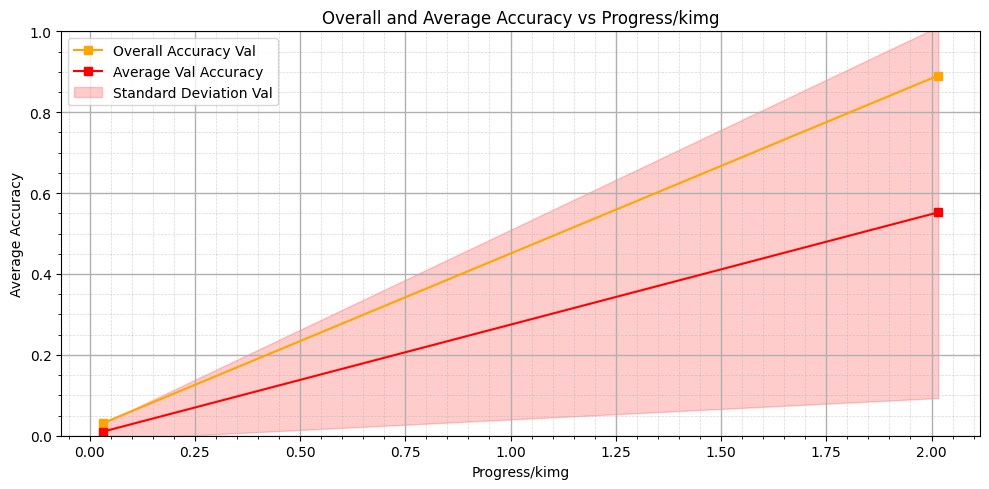

In [13]:
plot_accuracies(
    metrics,
    class_labels=class_labels,
    plot_std_in_avg_accuracy=True,
    plot_type="both",
    dataset="val",
)

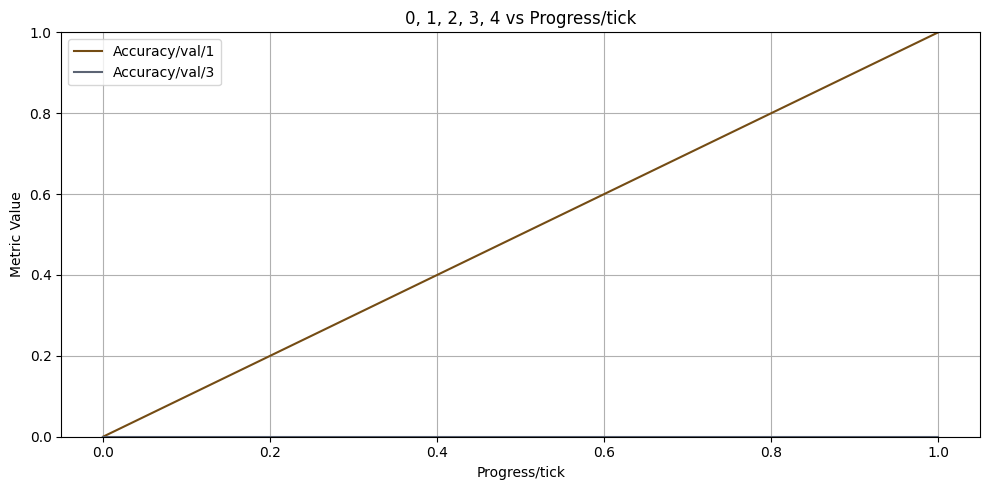

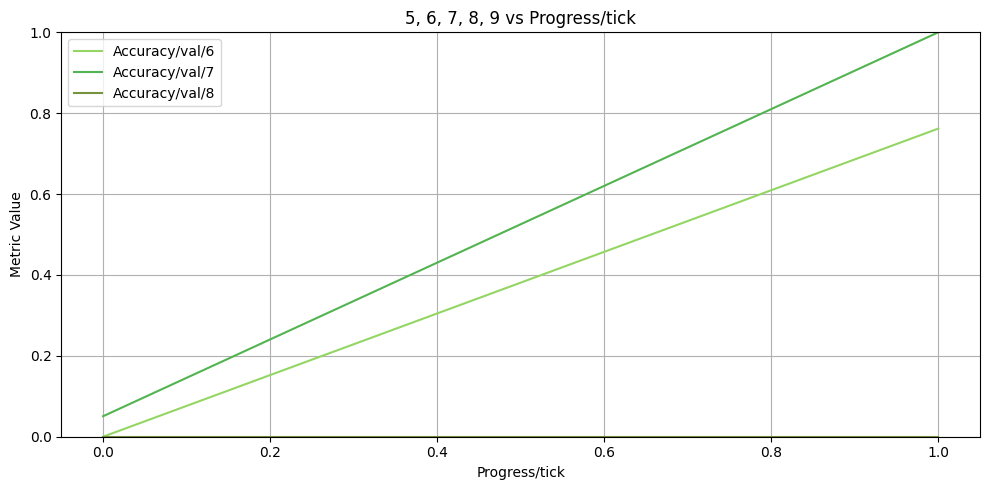

In [14]:
if "oitaven" in experiment_name:
    minority_class_labels = [1, 2, 3, 4, 5]
    colors = [class_colors[c] for c in minority_class_labels]
    plot_metric(
        metrics,
        metrics=[f"Accuracy/val/{c}" for c in minority_class_labels],
        x_axis="Progress/tick",
        marker=None,
        ylim=(0, 1),
        colors=colors,
        title="Terra, Pedras, Asfalto, Formigón, Tellados vs Progress/tick",
    )
    mayority_class_labels = [0, 6, 7, 8, 9]
    colors = [class_colors[c] for c in mayority_class_labels]
    plot_metric(
        metrics,
        metrics=[f"Accuracy/val/{c}" for c in mayority_class_labels],
        x_axis="Progress/tick",
        marker=None,
        ylim=(0, 1),
        colors=colors,
        title="Auga, Prados, Árbores Nativas, Piñeiros, Eucaliptos vs Progress/tick",
    )
else:
    first_class_labels = [0, 1, 2, 3, 4]
    colors = [class_colors[c] for c in first_class_labels]
    plot_metric(
        metrics,
        metrics=[f"Accuracy/val/{c}" for c in first_class_labels],
        x_axis="Progress/tick",
        marker=None,
        ylim=(0, 1),
        colors=colors,
        title="0, 1, 2, 3, 4 vs Progress/tick",
    )
    last_class_labels = [5, 6, 7, 8, 9]
    colors = [class_colors[c] for c in last_class_labels]
    plot_metric(
        metrics,
        metrics=[f"Accuracy/val/{c}" for c in last_class_labels],
        x_axis="Progress/tick",
        marker=None,
        ylim=(0, 1),
        colors=colors,
        title="5, 6, 7, 8, 9 vs Progress/tick",
    )

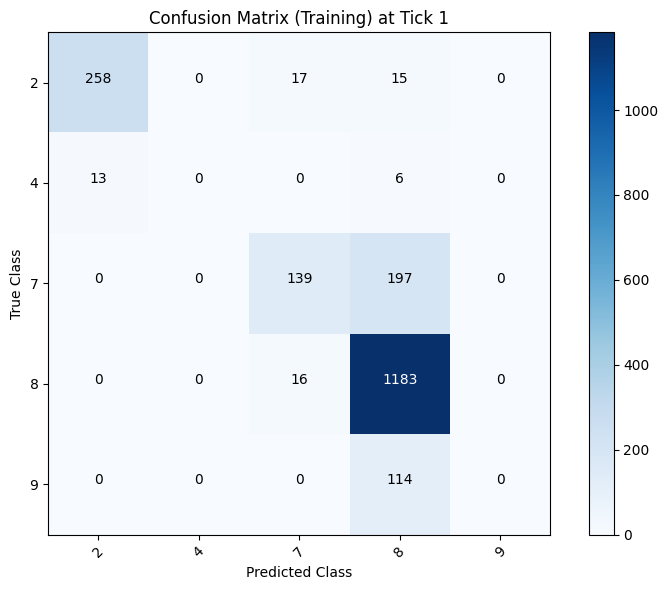

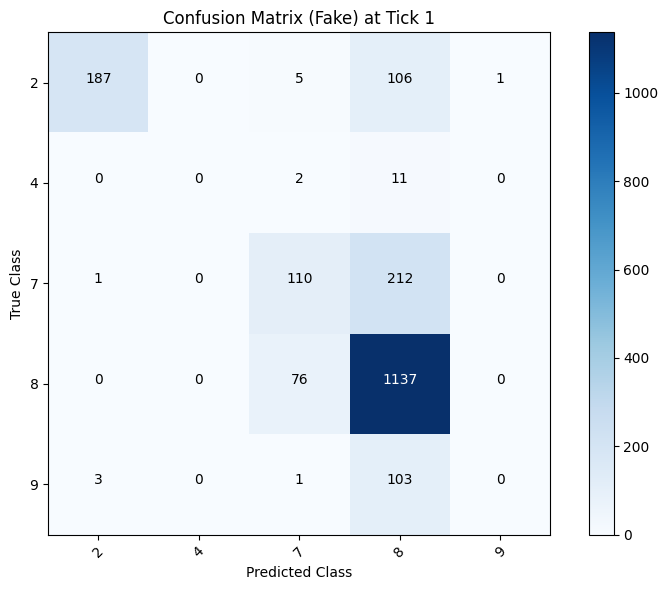

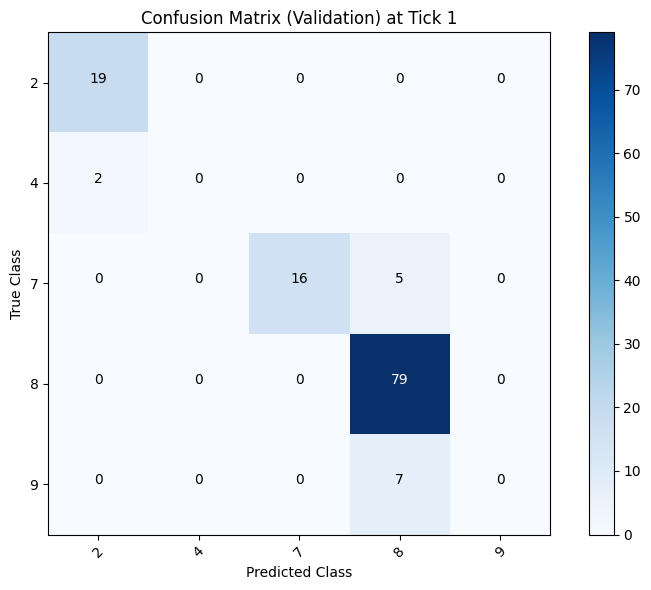

In [15]:
best_tick = int(best_tick_performance["tick"])
confusion_matrix = extract_confusion_matrix(
    jsonl_data, class_labels=class_labels, progress_tick=best_tick, data_type="real"
)
plot_confusion_matrix(
    confusion_matrix, class_labels=class_labels, title=f"Confusion Matrix (Training) at Tick {best_tick}"
)
confusion_matrix = extract_confusion_matrix(
    jsonl_data, class_labels=class_labels, progress_tick=best_tick, data_type="fake"
)
plot_confusion_matrix(confusion_matrix, class_labels=class_labels, title=f"Confusion Matrix (Fake) at Tick {best_tick}")
confusion_matrix = extract_confusion_matrix(
    jsonl_data, class_labels=class_labels, progress_tick=best_tick, data_type="val"
)
plot_confusion_matrix(
    confusion_matrix, class_labels=class_labels, title=f"Confusion Matrix (Validation) at Tick {best_tick}"
)